**FORKING**

In this notebook, we explore the concept of forking an already executed graph from a specific checkpoint and re-execute the same.

In [5]:
from json import load
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import MessagesState
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display, Image
from dotenv import load_dotenv

load_dotenv()

True

In [29]:
def add(a:int, b:int) -> int:
    """
    Adds two integer numbers

    Args:
        a (int): first integer
        b (int): second integer

    Returns:
        int: sum of two input integers
    """
    return a+b

def multiply(a:int, b:int) -> int:
    """
    Multiplies two integer numbers

    Args:
        a (int): first integer
        b (int): second integer

    Returns:
        int: product of two input integers
    """
    return a*b

def divide(a:int, b:int) -> float:
    """
    Divides two integer numbers

    Args:
        a (int): first integer
        b (int): second integer

    Returns:
        float: result of division operation between the two integers
    """
    return a/b

tools = [add, multiply, divide]

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_with_tools = llm.bind_tools(tools=tools)


In [26]:
# Create Graph and related elements,
# 1. System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# 2. Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

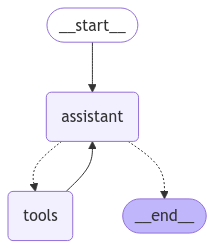

In [53]:
# 3. build graph

builder = StateGraph(MessagesState)

builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools=tools))

builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")

checkpointer = MemorySaver()

graph = builder.compile(checkpointer=checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
# Prepare input
prompt = {"messages":"What is 3 multipled with 5?"}

# Setup configuration
thread = {"configurable":{"thread_id":"2"}}

# Run
for event in graph.stream(prompt, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is 3 multipled with 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (b3e0b187-a2fd-49e8-b294-dd5922062491)
 Call ID: b3e0b187-a2fd-49e8-b294-dd5922062491
  Args:
    a: 3.0
    b: 5.0
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

15


In [59]:
# check history

all_states = list(graph.get_state_history(thread))
to_replay = all_states[-2]

In [61]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is 3 multipled with 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (4f0012f0-c230-46c5-9a79-170cd3c925e7)
 Call ID: 4f0012f0-c230-46c5-9a79-170cd3c925e7
  Args:
    a: 3.0
    b: 5.0
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

3 multiplied with 5 is 15.


In [70]:
to_fork = all_states[-2]
to_fork.config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efda7e8-2568-6418-8000-41955565ba16'}}

In [71]:
fork_config = graph.update_state(
    to_fork.config,
    {
        "messages":HumanMessage(
            content="What is 6 multiplied by 6?",
            id=to_fork.values["messages"][0].id
        )
    }
)

In [72]:
fork_config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efda7f2-d76b-61a2-8001-8f7b2b82f224'}}

In [77]:
list(graph.get_state(thread))

[{'messages': [HumanMessage(content='What is 6 multiplied by 6?', additional_kwargs={}, response_metadata={}, id='9db7bdcd-a6bd-434e-b0cf-83605e187e3d')]},
 ('assistant',),
 {'configurable': {'thread_id': '2',
   'checkpoint_ns': '',
   'checkpoint_id': '1efda7f2-d76b-61a2-8001-8f7b2b82f224'}},
 {'source': 'update',
  'writes': {'__start__': {'messages': HumanMessage(content='What is 6 multiplied by 6?', additional_kwargs={}, response_metadata={}, id='9db7bdcd-a6bd-434e-b0cf-83605e187e3d')}},
  'thread_id': '2',
  'step': 1,
  'parents': {},
  'checkpoint_ns': '',
  'checkpoint_id': '1efda7e8-2568-6418-8000-41955565ba16'},
 '2025-01-24T18:15:23.022948+00:00',
 {'configurable': {'thread_id': '2',
   'checkpoint_ns': '',
   'checkpoint_id': '1efda7e8-2568-6418-8000-41955565ba16'}},
 (PregelTask(id='cea884fc-d12d-99e3-ec41-db966e113c52', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),)]

In [78]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is 6 multiplied by 6?
================================== Ai Message ==================================
Tool Calls:
  multiply (ca661de7-ea0f-457a-9bfe-ec59f00068cc)
 Call ID: ca661de7-ea0f-457a-9bfe-ec59f00068cc
  Args:
    a: 6.0
    b: 6.0
================================= Tool Message =================================
Name: multiply

36
================================== Ai Message ==================================

36


In [79]:
list(graph.get_state_history(thread))

[StateSnapshot(values={'messages': [HumanMessage(content='What is 6 multiplied by 6?', additional_kwargs={}, response_metadata={}, id='9db7bdcd-a6bd-434e-b0cf-83605e187e3d'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 6.0, "b": 6.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-48c0b91d-ffa7-4790-a15f-819de68d57ee-0', tool_calls=[{'name': 'multiply', 'args': {'a': 6.0, 'b': 6.0}, 'id': 'ca661de7-ea0f-457a-9bfe-ec59f00068cc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 168, 'output_tokens': 3, 'total_tokens': 171, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='36', name='multiply', id='d02cf628-b4d7-41df-b339-25627de650c1', tool_call_id='ca661de7-ea0f-457a-9bfe-ec59f00068cc'), AIMessage(content='36', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_